In [111]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import pickle
import os
import missingno as msno
import shapely.io
from shapely.geometry import Point, LineString

from lxml import etree
from datetime import time

# Load GTFS data

https://github.com/matsim-org/matsim-libs/tree/master/examples/scenarios/pt-tutorial

In [112]:
gtfs_name = '20241211_010133_EMT_Valencia'

## Shapes

In [113]:
shapes_filename = f'data/redes/bus/{gtfs_name}/shapes.txt'

shapes = pd.read_csv(shapes_filename)
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,SHP_185_I,39.484123,-0.391542,0,0.0
1,SHP_185_I,39.485841,-0.390737,1,203.0
2,SHP_185_I,39.485841,-0.390737,2,203.0
3,SHP_185_I,39.487875,-0.389816,3,442.0
4,SHP_185_I,39.487875,-0.389816,4,442.0
...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0


In [114]:
shapes['geometry'] = shapes.apply(lambda row: Point(row['shape_pt_lon'], row['shape_pt_lat']), axis='columns')
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (-0.39154151357175 39.4841225310996)
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (-0.390737093638577 39.4858407277057)
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (-0.390737093638577 39.4858407277057)
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (-0.389815625206019 39.4878754804054)
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (-0.389815625206019 39.4878754804054)
...,...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (-0.413260844324026 39.4697315368409)
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (-0.413268952564266 39.4697310416539)
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (-0.413271655644534 39.46973086759)
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0,POINT (-0.413919991912794 39.4696883517495)


In [115]:
edges = shapes.groupby('shape_id')['geometry'].apply(lambda x: LineString(x.to_list()))
edges = gpd.GeoDataFrame(edges, geometry='geometry')
edges = edges.set_crs('EPSG:4326')
edges

,geometry
shape_id,
SHP_1007_I,"LINESTRING (-0.41719 39.4684, -0.41737 39.4684..."
SHP_1007_V,"LINESTRING (-0.3457 39.47925, -0.34615 39.4782..."
SHP_1017_I,"LINESTRING (-0.3763 39.47061, -0.37613 39.4703..."
SHP_1017_V,"LINESTRING (-0.33179 39.44742, -0.33195 39.447..."
SHP_1018_I,"LINESTRING (-0.37837 39.46796, -0.3785 39.468,..."
...,...
SHP_995_V,"LINESTRING (-0.40417 39.49014, -0.40409 39.490..."
SHP_996_I,"LINESTRING (-0.38776 39.48015, -0.38804 39.480..."
SHP_996_V,"LINESTRING (-0.35594 39.47516, -0.35588 39.475..."


<Axes: >

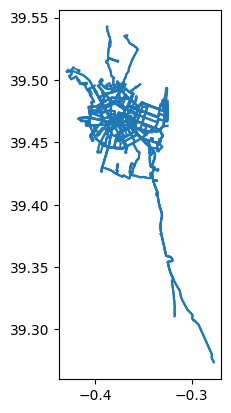

In [116]:
edges.plot()

In [117]:
if not os.path.exists('data/redes/bus/emt_shp/'):
    os.mkdir('data/redes/bus/emt_shp/')

edges.to_file('data/redes/bus/emt_shp/emt_edges.shp', driver='ESRI Shapefile')

## Stops

In [118]:
stops_filename = f'data/redes/bus/{gtfs_name}/stops.txt'

stops = pd.read_csv(stops_filename)
stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,10,10,Doctor Lluch - Mediterrània,C DOCTOR LLUCH 99 (DAVANT) - VALÈNCIA,39.467234,-0.328306,NaN,NaN,0,NaN
1,1007,1007,Jesús Morante Borrás (I),AV JESUS MORANTE BORRAS 26 - VALÈNCIA,39.451015,-0.345435,NaN,NaN,0,NaN
2,1008,1008,Jesús Morante Borrás (II),AV JESUS MORANTE BORRAS 54 - VALÈNCIA,39.449483,-0.344468,NaN,NaN,0,NaN
3,1009,1009,Jesús Morante Borrás (III),AV JESUS MORANTE BORRAS 86 - VALÈNCIA,39.447905,-0.344029,NaN,NaN,0,NaN
4,1010,1010,Jesús Morante Borrás (IV),AV JESUS MORANTE BORRAS 158 - VALÈNCIA,39.444148,-0.343987,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
1141,978,978,Carters (parell) - Primer de Maig,C CARTEROS 84 - VALÈNCIA,39.448198,-0.389623,NaN,NaN,0,NaN
1142,979,979,Carters - Mossén Febrer,C CARTEROS 60 (DAVANT) - VALÈNCIA,39.450171,-0.388974,NaN,NaN,0,NaN
1143,983,983,Ramón y Cajal - Bailén,GV RAMON Y CAJAL 1 - VALÈNCIA,39.463089,-0.379623,NaN,NaN,0,NaN
1144,985,985,Centre de Salut Benimaclet,C JAIME ESTEVE CUBELLS 6 - VALÈNCIA,39.483322,-0.358504,NaN,NaN,0,NaN


In [119]:
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis='columns')

<Axes: >

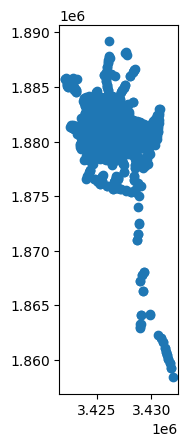

In [120]:
stops = gpd.GeoDataFrame(stops, geometry='geometry', crs='EPSG:4326')
stops = stops.to_crs('EPSG:3035')
stops.plot()

In [121]:
# if not os.path.exists('data/redes/bus/emt_shp/'):
#     os.mkdir('data/redes/bus/emt_shp/')
# 
# stops.to_file('data/redes/bus/emt_shp/emt_nodes.shp', driver='ESRI Shapefile')

In [122]:
stops.loc[stops['stop_id'].isin([1380, 1381])]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,geometry
175,1380,1380,Punta al Mar (imparell) - Canal,CAMI PUNTA AL MAR DE LA 57 - VALÈNCIA,39.445217,-0.337349,NaN,NaN,0,NaN,POINT (3429097.005 1877882.718)
176,1381,1381,Punta al Mar (imparell) - Riu,CAMI PUNTA AL MAR DE LA 29 - VALÈNCIA,39.445554,-0.340578,NaN,NaN,0,NaN,POINT (3428824.921 1877957.583)


## Routes

In [123]:
routes_filename = f'data/redes/bus/{gtfs_name}/routes.txt'

routes = pd.read_csv(routes_filename)
routes

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,23,EMT,23,POBLES DEL SUD,NaN,3,NaN,FE0000,FFFFFF
1,24,EMT,24,PORTA DE LA MAR - EL SALER / EL PALMAR,NaN,3,NaN,FE0000,FFFFFF
2,5,EMT,C1,CENTRE HISTÒRIC,NaN,3,NaN,FE0000,FFFFFF
3,63,EMT,63,CAMPUS DE BURJASSOT - ESTACIÓ DEL NORD,NaN,3,NaN,FE0000,FFFFFF
4,28,EMT,28,CIUTAT ART. FALLER - ESTACIÓ DEL NORD,NaN,3,NaN,FE0000,FFFFFF
5,95,EMT,95,JARDÍ DEL TÚRIA,NaN,3,NaN,FE0000,FFFFFF
6,4,EMT,4,PORT/NATZARET - POETA QUEROL,NaN,3,NaN,FE0000,FFFFFF
7,6,EMT,6,TORREFIEL - HOSPITAL LA FE,NaN,3,NaN,FE0000,FFFFFF
8,7,EMT,7,MERCAT CENTRAL - FTA. SANT LLUÍS,NaN,3,NaN,FE0000,FFFFFF
9,8,EMT,8,PORTA DE LA MAR - HOSPITAL LA FE,NaN,3,NaN,FE0000,FFFFFF


## Trips

In [124]:
trips_filename = f'data/redes/bus/{gtfs_name}/trips.txt'

trips = pd.read_csv(trips_filename)
trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,23,FES,1033D2V0,Porta de la Mar,0,10332,SHP_1033_V
1,23,FES,1033D2V1,Forn d'Alcedo,0,10332,SHP_1033_I
2,23,FES,1033D2V2,Porta de la Mar,0,10332,SHP_1033_V
3,23,FES,1033D2V3,Forn d'Alcedo,0,10332,SHP_1033_I
4,23,FES,1033D2V4,Porta de la Mar,0,10332,SHP_1033_V
...,...,...,...,...,...,...,...
2365,93,FES,994D2V,Av. del Cid,0,9942,SHP_994_V
2366,93,LAB,994D0I,Passeig Maritim,0,9940,SHP_994_I
2367,93,LAB,994D0V,Av. del Cid,0,9940,SHP_994_V
2368,93,SAB,994D1I,Passeig Maritim,0,9941,SHP_994_I


In [125]:
trips.loc[trips['trip_id'].eq('968D0V53')]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
337,63,LAB,968D0V53,Estació del Nord,0,9680,SHP_968_V


In [126]:
trips['trip_id'].nunique()

2370

## Frequencies

In [127]:
frequencies_filename = f'data/redes/bus/{gtfs_name}/frequencies.txt'

has_frequencies = False

try:
    frequencies = pd.read_csv(frequencies_filename)
    has_frequencies = True
except:
    print('Frequencies file not found')

In [128]:
if has_frequencies:
    frequencies['start_time'] = frequencies['start_time'].astype('timedelta64[s]')
    frequencies['end_time'] = frequencies['end_time'].astype('timedelta64[s]')

## Stop times

In [129]:
stop_times_filename = f'data/redes/bus/{gtfs_name}/stop_times.txt'

stop_times = pd.read_csv(stop_times_filename)
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN


In [130]:
# assuming only on departure time
stop_times_departures = stop_times.groupby('trip_id')[['arrival_time', 'departure_time']].first().reset_index()

In [131]:
# convert arrivals and departures to timedelta (what happens when we go over 1 day?)
stop_times_departures['arrival_time'] = stop_times_departures['arrival_time'].astype('timedelta64[s]')
stop_times_departures['departure_time'] = stop_times_departures['departure_time'].astype('timedelta64[s]')


stop_times_departures = stop_times_departures.rename(columns={'arrival_time': 'arrival_time_original'})
stop_times_departures = stop_times_departures.rename(columns={'departure_time': 'departure_time_original'})
stop_times_departures

,trip_id,arrival_time_original,departure_time_original
0,1007D0I,0 days,0 days
1,1007D0V,0 days,0 days
2,1007D1I,0 days,0 days
3,1007D1V,0 days,0 days
4,1007D2I,0 days,0 days
...,...,...,...
2365,997D0V,0 days,0 days
2366,997D1I,0 days,0 days
2367,997D1V,0 days,0 days
2368,997D2I,0 days,0 days


In [132]:
# merging stop_times with stop_times_departures -> copies of first row arrival and departure times in front of every stop in the trip
stop_times_merged = stop_times.merge(stop_times_departures, on='trip_id', how='left')
stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_original,departure_time_original
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
...,...,...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00


In [133]:
# adding a boolean flag if the trip is in frequencies.txt
# stop_times_merged['is_relative'] = stop_times_merged['trip_id'].isin(frequencies['trip_id'])
stop_times_merged['is_relative'] = False
stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_original,departure_time_original,is_relative
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,False
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,False
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,False
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,False


In [134]:
# define a helper function for timestamp to str conversion
def timedelta_to_str(timedelta):
    return f"{int(timedelta.total_seconds() // 3600):02}:{int((timedelta.total_seconds() % 3600) // 60):02}:{int(timedelta.total_seconds() % 60):02}"

In [135]:
# substracting first row arrival time from arrival times of all stops -> relative arrivals
stop_times_merged['arrival_time_offset'] = stop_times_merged['arrival_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time_original']
# substracting first row arrival time from departure times of all stops -> relative departures
stop_times_merged['departure_time_offset'] = stop_times_merged['arrival_time_offset'] + stop_times_merged['departure_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time'].astype('timedelta64[s]') #+ pd.to_timedelta('00:00:10')

# get string representations for MATSim
stop_times_merged['arrival_time_offset_str'] = stop_times_merged['arrival_time_offset'].apply(lambda x: timedelta_to_str(x))
stop_times_merged['departure_time_offset_str'] = stop_times_merged['departure_time_offset'].apply(lambda x: timedelta_to_str(x))

stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_original,departure_time_original,is_relative,arrival_time_offset,departure_time_offset,arrival_time_offset_str,departure_time_offset_str
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:00:00,0 days 00:02:00,00:00:00,00:02:00
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:02:27,0 days 00:02:27,00:02:27,00:02:27
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:02:42,0 days 00:02:42,00:02:42,00:02:42
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:03:11,0 days 00:03:11,00:03:11,00:03:11
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:04:57,0 days 00:04:57,00:04:57,00:04:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,False,0 days 00:28:30,0 days 00:28:30,00:28:30,00:28:30
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,False,0 days 00:29:21,0 days 00:29:21,00:29:21,00:29:21
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,False,0 days 00:31:34,0 days 00:31:34,00:31:34,00:31:34
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,False,0 days 00:32:22,0 days 00:32:22,00:32:22,00:32:22


## Calendar

In [136]:
calendar_filename = f'data/redes/bus/{gtfs_name}/calendar.txt'

if os.path.exists(calendar_filename):
    has_calendar = pd.read_csv(calendar_filename).shape[0] > 0
else:
    has_calendar = False

if has_calendar:
    calendar = pd.read_csv(calendar_filename, parse_dates=['start_date', 'end_date'])
    print(calendar)
else:
    print(f'There is no calendar file or it\'s empty')

  service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0        LAB       1        1          1         1       1         0       0   
1        SAB       0        0          0         0       0         1       0   
2        FES       0        0          0         0       0         0       1   
3       NLAB       1        1          1         0       0         0       1   
4        NFS       0        0          0         1       1         1       0   
5    L38-755       1        1          1         1       1         1       1   
6    L38-810       1        1          1         1       1         1       1   
7       VLAB       1        1          1         1       1         0       0   
8       VSAB       0        0          0         0       0         1       0   
9       VFES       0        0          0         0       0         0       1   

  start_date   end_date  
0 2024-01-01 2026-12-31  
1 2024-01-01 2026-12-31  
2 2024-01-01 2026-12-31  
3 2024-01-01 20

## Calendar dates

In [137]:
calendar_dates_filename = f'data/redes/bus/{gtfs_name}/calendar_dates.txt'

if os.path.exists(calendar_dates_filename):
    has_calendar_dates = pd.read_csv(calendar_dates_filename).shape[0] > 0
else:
    has_calendar_dates = False

if has_calendar_dates:
    calendar_dates = pd.read_csv(calendar_dates_filename, parse_dates=['date'])
    print(calendar_dates)
else:
    print(f'There is no calendar dates file or it\'s empty')


   service_id       date  exception_type
0         LAB 2024-01-22               2
1         FES 2024-01-22               1
2         LAB 2025-01-01               2
3         FES 2025-01-01               1
4         LAB 2025-01-06               2
..        ...        ...             ...
81       NFES 2024-04-30               1
82       NLAB 2024-10-08               2
83       NFES 2024-10-08               1
84       NLAB 2024-12-24               2
85       NFES 2024-12-24               1

[86 rows x 3 columns]


# Prepare MATSim configs

## Create nodes

Nodes are created from `stops.txt` geometry column

In [138]:
nodes_original = stops.loc[:, ['stop_id', 'stop_name', 'geometry']]
nodes_original

,stop_id,stop_name,geometry
0,10,Doctor Lluch - Mediterrània,POINT (3430171.588 1880191.51)
1,1007,Jesús Morante Borrás (I),POINT (3428483.307 1878613.505)
2,1008,Jesús Morante Borrás (II),POINT (3428545.216 1878434.112)
3,1009,Jesús Morante Borrás (III),POINT (3428561.35 1878255.962)
4,1010,Jesús Morante Borrás (IV),POINT (3428513.669 1877843.33)
...,...,...,...
1141,978,Carters (parell) - Primer de Maig,POINT (3424659.198 1878824.318)
1142,979,Carters - Mossén Febrer,POINT (3424741.82 1879033.107)
1143,983,Ramón y Cajal - Bailén,POINT (3425719.575 1880339.622)
1144,985,Centre de Salut Benimaclet,POINT (3427804.822 1882310.329)


In [139]:
nodes_original.loc[:, 'node_id'] = nodes_original['stop_id'].astype('str')

In [140]:
nodes_extra = nodes_original.copy()
nodes_extra['node_id'] = nodes_extra['node_id'] + 'X'

In [141]:
nodes = pd.concat([nodes_original, nodes_extra], axis='index', ignore_index=True).reset_index(drop=True)
nodes

,stop_id,stop_name,geometry,node_id
0,10,Doctor Lluch - Mediterrània,POINT (3430171.588 1880191.51),10
1,1007,Jesús Morante Borrás (I),POINT (3428483.307 1878613.505),1007
2,1008,Jesús Morante Borrás (II),POINT (3428545.216 1878434.112),1008
3,1009,Jesús Morante Borrás (III),POINT (3428561.35 1878255.962),1009
4,1010,Jesús Morante Borrás (IV),POINT (3428513.669 1877843.33),1010
...,...,...,...,...
2287,978,Carters (parell) - Primer de Maig,POINT (3424659.198 1878824.318),978X
2288,979,Carters - Mossén Febrer,POINT (3424741.82 1879033.107),979X
2289,983,Ramón y Cajal - Bailén,POINT (3425719.575 1880339.622),983X
2290,985,Centre de Salut Benimaclet,POINT (3427804.822 1882310.329),985X


<Axes: >

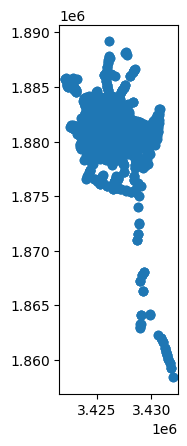

In [142]:
nodes = gpd.GeoDataFrame(nodes, geometry='geometry', crs='EPSG:3035')
nodes.plot()

## Map trips to stops

In [143]:
trips_to_stops = stop_times.groupby('trip_id')['stop_id'].apply(lambda x: [str(stop_id) for stop_id in x])
trips_to_stops

trip_id
1007D0I    [1366, 2004, 2005, 2006, 2007, 1223, 498, 529,...
1007D0V    [1282, 1114, 112, 113, 114, 154, 155, 158, 160...
1007D1I    [1366, 2004, 2005, 2006, 2007, 1223, 498, 529,...
1007D1V    [1282, 1114, 112, 113, 114, 154, 155, 158, 160...
1007D2I    [1366, 2004, 2005, 2006, 2007, 1223, 498, 529,...
                                 ...                        
997D0V     [1946, 1947, 1964, 1965, 592, 593, 594, 1350, ...
997D1I     [1824, 1825, 445, 1826, 958, 1684, 1183, 1184,...
997D1V     [1946, 1947, 1964, 1965, 592, 593, 594, 1350, ...
997D2I     [1824, 1825, 445, 1826, 958, 1684, 1183, 1184,...
997D2V     [1946, 1947, 1964, 1965, 592, 593, 594, 1350, ...
Name: stop_id, Length: 2370, dtype: object

In [144]:
trips_to_stops_exploded = trips_to_stops.explode()
trips_to_stops_exploded

trip_id
1007D0I    1366
1007D0I    2004
1007D0I    2005
1007D0I    2006
1007D0I    2007
           ... 
997D2V     1848
997D2V     1849
997D2V     1850
997D2V     2389
997D2V     1824
Name: stop_id, Length: 66632, dtype: object

## Create edges

Edges are created from trips and trip-to-stop mapping 

In [145]:
edges_original = trips_to_stops_exploded.copy().to_frame()

In [146]:
edges_original.loc[:, 'destination'] = edges_original.groupby('trip_id')['stop_id'].shift(-1)
edges_original = edges_original.rename(columns={'stop_id':'origin'})
edges_original = edges_original.dropna()
edges_original = edges_original.reset_index(drop=True)
edges_original = edges_original.drop_duplicates()
edges_original.head()

,origin,destination
0,1366,2004
1,2004,2005
2,2005,2006
3,2006,2007
4,2007,1223


In [147]:
# add artificial links ... -> ...X

origins = nodes_original['node_id']
destinations = nodes_extra['node_id']

edges_to_add = pd.concat([origins, destinations], axis='columns', ignore_index=True)
edges_to_add.columns = ['origin', 'destination']
edges_to_add.head()

,origin,destination
0,10,10X
1,1007,1007X
2,1008,1008X
3,1009,1009X
4,1010,1010X


In [148]:
# change origin nodex to ...X nodes
edges = edges_original.copy()
edges['origin'] = edges['origin'] + 'X'

In [149]:
edges = pd.concat([edges, edges_to_add], axis='index', ignore_index=True).reset_index(drop=True)
edges.shape

(2533, 2)

In [150]:
edges = pd.merge(edges, nodes.loc[:, ['node_id', 'geometry']], left_on='origin', right_on='node_id', how='left').rename(columns={'geometry':'geometry_origin'}).drop(columns='node_id')
edges = pd.merge(edges, nodes.loc[:, ['node_id', 'geometry']], left_on='destination', right_on='node_id').rename(columns={'geometry':'geometry_destination'}).drop(columns='node_id')
edges

,origin,destination,geometry_origin,geometry_destination
0,1366X,2004,POINT (3422579.404 1881371.058),POINT (3422793.435 1881418.538)
1,2004X,2005,POINT (3422793.435 1881418.538),POINT (3422796.395 1881231.847)
2,2005X,2006,POINT (3422796.395 1881231.847),POINT (3422949.297 1881156.373)
3,2006X,2007,POINT (3422949.297 1881156.373),POINT (3423190.806 1881135.572)
4,2007X,1223,POINT (3423190.806 1881135.572),POINT (3423484.991 1881080.855)
...,...,...,...,...
2528,978,978X,POINT (3424659.198 1878824.318),POINT (3424659.198 1878824.318)
2529,979,979X,POINT (3424741.82 1879033.107),POINT (3424741.82 1879033.107)
2530,983,983X,POINT (3425719.575 1880339.622),POINT (3425719.575 1880339.622)
2531,985,985X,POINT (3427804.822 1882310.329),POINT (3427804.822 1882310.329)


In [151]:
edges.loc[:, 'geometry'] = edges.apply(lambda row: LineString((row['geometry_origin'], row['geometry_destination'])), axis='columns')
edges = edges.drop(columns=['geometry_origin', 'geometry_destination'])
edges

,origin,destination,geometry
0,1366X,2004,LINESTRING (3422579.404461485 1881371.05784744...
1,2004X,2005,LINESTRING (3422793.434699223 1881418.53831426...
2,2005X,2006,LINESTRING (3422796.395362111 1881231.84746315...
3,2006X,2007,LINESTRING (3422949.296897729 1881156.37272039...
4,2007X,1223,LINESTRING (3423190.8061549542 1881135.5716381...
...,...,...,...
2528,978,978X,LINESTRING (3424659.1984227286 1878824.3180458...
2529,979,979X,LINESTRING (3424741.8200177588 1879033.1073421...
2530,983,983X,LINESTRING (3425719.5750214644 1880339.6223246...
2531,985,985X,LINESTRING (3427804.82154642 1882310.328840229...


In [152]:
edges = gpd.GeoDataFrame(edges, geometry='geometry', crs='EPSG:3035')

In [153]:
edges['length'] = edges['geometry'].length
edges['edge_id'] = edges['origin'].astype('str') + '_' + edges['destination'].astype('str')

<Axes: >

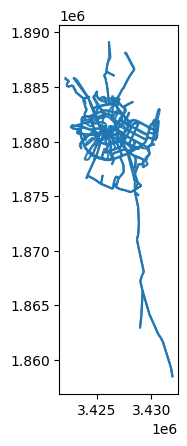

In [154]:
edges.plot()

In [155]:
edges.dtypes

origin           object
destination      object
geometry       geometry
length          float64
edge_id          object
dtype: object

## Network to XML (`network.xml`)

In [156]:
version = 2
graph_to_load = 'v' + str(version)

In [157]:
root = etree.Element('network', name=f'{gtfs_name}_network_' + graph_to_load)

## GENERATING NODES

nodes_item = etree.SubElement(root, 'nodes')

for _, node in nodes.iterrows():
    
    nodes_item.append(etree.Element('node',
                                    id=str(node['node_id']), 
                                    x=str(node['geometry'].coords.xy[0][0]), 
                                    y=str(node['geometry'].coords.xy[1][0])))

## GENERATING LINKS

links_item = etree.SubElement(root, 'links')

for _, link in edges.iterrows():

    from_node = str(link['origin'])
    to_node = str(link['destination'])
    
    link_item = etree.SubElement(links_item, 'link')

    link_item.set('id', link['edge_id'])
    link_item.set('from', str(from_node))
    link_item.set('to', str(to_node))
    link_item.set('freespeed', str(10))
    link_item.set('capacity', str(100))
    link_item.set('permlanes', str(1))
    link_item.set('length', str(link['length']))
    link_item.set('modes', 'pt')

doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v1.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

if not os.path.exists(os.path.join(os.getcwd(), f'networks_emt_v{version}')):
    os.mkdir(f'networks_emt_v{version}')
    
with open(f'networks_emt_v{version}/network_' + graph_to_load + '.xml', 'wb') as file:
    file.write(final_xml)

## Input date

The date introduced is used to generate transit schedules for this day in particular.

`calendat.txt` and `calendar_dates.txt` are checked to filter the schedule.

In [158]:
date_to_check = pd.to_datetime('2025-03-10')

weekday_names = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

In [159]:
print(f'calendar.txt is {' not' * (not has_calendar)} available.' )
print(f'calendar_dates.txt is {' not' * (not has_calendar_dates)} available.' )

# if we have both files
if has_calendar & has_calendar_dates:
    
    # CHECK CALENDAR
    # define conditions to filter calendars 
    condition_date_range = calendar['start_date'].le(date_to_check) & calendar['end_date'].ge(date_to_check)
    condition_weekday = calendar[weekday_names[date_to_check.weekday()]].eq(1)
    
    # preliminarly filter by conditions
    relevant_service_ids = calendar.loc[condition_date_range & condition_weekday, 'service_id']
    
    # CHECK CALENDAR DATES
    if relevant_service_ids.shape[0] > 0:
        if date_to_check in calendar_dates['date'].values:
            service_ids_to_add = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), 'service_id']
            service_ids_to_delete = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(2), 'service_id']
            
            # adding service ids
            relevant_service_ids = pd.concat([relevant_service_ids, calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_add), :]], axis='index')
            print(f'Added: {service_ids_to_add}')
            
            # removing service ids
            relevant_service_ids_merged = pd.merge(relevant_service_ids, calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_delete), :], how='left', indicator=True)
            relevant_service_ids = relevant_service_ids_merged.loc[relevant_service_ids_merged['_merge'].ne('both')].drop(columns='_merge')
            print(f'Deleted: {service_ids_to_delete}')
        else:
            print('No changes were made to the candidate list.')
    else:
        if date_to_check in calendar_dates['date'].values:
            if calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), :].shape[0] > 0:
                pass # add exception
        else:
            print('No service_id found for this date.')
# if we have calendar only
elif has_calendar & (not has_calendar_dates):
    # define conditions to filter calendars 
    condition_date_range = calendar['start_date'].le(date_to_check) & calendar['end_date'].ge(date_to_check)
    condition_weekday = calendar[weekday_names[date_to_check.weekday()]].eq(1)
    
    # preliminarly filter by conditions
    relevant_service_ids = calendar.loc[condition_date_range & condition_weekday]
# if we have calendar_dates only
else:
    relevant_service_ids = []
    
    if date_to_check in calendar_dates['date'].values:
        service_ids_to_add = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), 'service_id']
        
        # adding service ids
        relevant_service_ids = service_ids_to_add
        print(f'Added: {service_ids_to_add}')


calendar.txt is  available.
calendar_dates.txt is  available.
No changes were made to the candidate list.


In [160]:
relevant_service_ids

0        LAB
3       NLAB
5    L38-755
6    L38-810
Name: service_id, dtype: object

## To XML (transitSchedule.xml)

In [161]:
# create artificial links sequence
route_links_extra = trips_to_stops_exploded.copy().to_frame()
route_links_extra['stop_id'] = route_links_extra['stop_id'] + 'X'

route_links_extra = pd.concat([trips_to_stops_exploded.copy().to_frame(), route_links_extra], axis='columns')
route_links_extra.columns = ['origin', 'destination']
route_links_extra = route_links_extra.reset_index()
route_links_extra.head()

,trip_id,origin,destination
0,1007D0I,1366,1366X
1,1007D0I,2004,2004X
2,1007D0I,2005,2005X
3,1007D0I,2006,2006X
4,1007D0I,2007,2007X


In [162]:
# create real links sequence
route_links_original = route_links_extra.copy()

route_links_original.loc[:, 'origin_shifted'] = route_links_original.groupby('trip_id')['origin'].shift(-1)
route_links_original = route_links_original.drop(columns=['origin'])
route_links_original = route_links_original.dropna()
route_links_original.columns = ['trip_id', 'origin', 'destination']
route_links_original

,trip_id,origin,destination
0,1007D0I,1366X,2004
1,1007D0I,2004X,2005
2,1007D0I,2005X,2006
3,1007D0I,2006X,2007
4,1007D0I,2007X,1223
...,...,...,...
66626,997D2V,1847X,1848
66627,997D2V,1848X,1849
66628,997D2V,1849X,1850
66629,997D2V,1850X,2389


In [163]:
route_links = pd.concat([route_links_extra, 
           route_links_original], axis='index', ignore_index=False).reset_index().sort_values(by=['index', 'origin'])
route_links

,index,trip_id,origin,destination
0,0,1007D0I,1366,1366X
66632,0,1007D0I,1366X,2004
1,1,1007D0I,2004,2004X
66633,1,1007D0I,2004X,2005
2,2,1007D0I,2005,2005X
...,...,...,...,...
66629,66629,997D2V,1850,1850X
130892,66629,997D2V,1850X,2389
66630,66630,997D2V,2389,2389X
130893,66630,997D2V,2389X,1824


In [164]:
relevant_service_ids

0        LAB
3       NLAB
5    L38-755
6    L38-810
Name: service_id, dtype: object

In [165]:
trips_filtered = trips.loc[trips['service_id'].isin(relevant_service_ids), :]
routes_filtered = routes.loc[routes['route_id'].isin(trips_filtered['route_id'].unique())]

trips.shape, trips_filtered.shape, routes.shape, routes_filtered.shape

((2370, 7), (581, 7), (45, 9), (44, 9))

In [166]:
vehicle_counter = 0

In [167]:
root = etree.Element('transitSchedule')


transit_stops_item = etree.SubElement(root, 'transitStops')

# STOP FACILITIES from original stops
for _, stop_facility in nodes_original.iterrows():
    
    stop_facility_id = stop_facility['node_id']

    transit_stops_item.append(etree.Element('stopFacility', 
                                            id=stop_facility_id, 
                                            x=str(stop_facility['geometry'].coords.xy[0][0]), 
                                            y=str(stop_facility['geometry'].coords.xy[1][0]),
                                            linkRefId=f'{stop_facility_id}_{stop_facility_id}X'
                                            ))
    
# TRANSIT LINES from routes
for _, route in routes_filtered.iterrows():
    
    transit_line_item = etree.SubElement(root, 'transitLine', 
                                          id=str(route['route_id']),
                                          name=str(route['route_short_name']))
    
    # TRANSIT ROUTE
    # filtering trips (transitRoute) for this route (transitLine) only
    trips_filtered_again = trips_filtered.loc[trips_filtered['route_id'].eq(route['route_id']),:]
    
    for _, trip in trips_filtered_again.iterrows():
        
        transit_route_item = etree.SubElement(transit_line_item, 'transitRoute', 
                                              id=str(trip['trip_id']))
        
        # TRANSIT MODE
        transit_mode_item = etree.SubElement(transit_route_item, 'transportMode')
        transit_mode_item.text = "pt"
    
        routes_profile_item = etree.SubElement(transit_route_item, 'routeProfile')
        
        # ROUTE PROFILE
        # filtering stop_times for the current trip only
        stop_times_filtered = stop_times_merged.loc[stop_times_merged['trip_id'].eq(trip['trip_id']),:]
        
        is_first_stop = True
        last_stop_index = stop_times_filtered.tail(1).index
        for _, stop_time in stop_times_filtered.iterrows():
            
            stop_id = str(stop_time['stop_id'])
            
            if is_first_stop:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     departureOffset=str(stop_time['departure_time_offset_str']),
                                                     awaitDeparture="true"
                                                     # arrivalOffset=str(stop_time['arrival_time_offset_str'])
                                                         ))
                is_first_stop = False
            elif _ == last_stop_index:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     # departureOffset=str(stop_time['departure_time_offset_str']),
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str']),
                                                     awaitDeparture="true"
                                                     ))
            else:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str']),
                                                     departureOffset=str(stop_time['departure_time_offset_str']),
                                                     awaitDeparture="true"
                                                     ))

        # ROUTE (all the links for a specific route, not only the ones with stops)
        route_item = etree.SubElement(transit_route_item, 'route')
        
        route_links_filtered = route_links.loc[route_links['trip_id'].eq(trip['trip_id']), :]
        # print(route_links_filtered.shape)
        
        for _, route_link in route_links_filtered.iterrows():
            route_item.append(etree.Element('link', 
                                            refId=f'{route_link['origin']}_{route_link['destination']}'))
        
        # DEPARTURES
        departures_item = etree.SubElement(transit_route_item, 'departures')
        
        if has_frequencies:
            # if there is a frequency for a trip, ...
            if trip['trip_id'] in frequencies['trip_id'].values:
                # print(f'Trip {trip['trip_id']} has a frequency')
                # ...generate a departure for every frequency
                
                # filtering frequencies for the current trip only
                frequencies_filtered = frequencies.loc[frequencies['trip_id'].eq(trip['trip_id']),:]
                
                for _, frequency in frequencies_filtered.iterrows(): # in every frequency there is an interval with it's frequency in seconds 
                    departures = pd.timedelta_range(start=frequency['start_time'], 
                                                    end=frequency['end_time'], 
                                                    freq=str(frequency['headway_secs']) + 's', 
                                                    closed='left')
                    
                    for departure_index, departure in enumerate(departures):
                        vehicle_counter = vehicle_counter + 1
    
                        vehicleRefId = 'veh_' + str(vehicle_counter)
    
                        departures_item.append(etree.Element('departure', 
                                                             id=str(_) + '_' + str(departure_index),
                                                             departureTime=timedelta_to_str(departure),
                                                             vehicleRefId=vehicleRefId
                                                             ))
            # if there is no frequency for a trip, ...
            else:
                vehicle_counter = vehicle_counter + 1
                
                vehicleRefId = 'veh_' + str(vehicle_counter)
    
                # ...generate only one departure from stop_times_departures
                single_departure = stop_times_filtered.loc[stop_times_filtered['trip_id'].eq(trip['trip_id']),'departure_time_original'].iloc[0]
                departures_item.append(etree.Element('departure', 
                                                         id=str(_),
                                                         departureTime=timedelta_to_str(single_departure),
                                                         vehicleRefId=vehicleRefId
                                                     ))
        else:
            vehicle_counter = vehicle_counter + 1
            
            vehicleRefId = 'veh_' + str(vehicle_counter)

            # ...generate only one departure from stop_times_departures
            single_departure = stop_times_filtered.loc[stop_times_filtered['trip_id'].eq(trip['trip_id']),'departure_time_original'].iloc[0]
            departures_item.append(etree.Element('departure', 
                                                     id=str(_),
                                                     departureTime=timedelta_to_str(single_departure),
                                                     vehicleRefId=vehicleRefId
                                                 ))

doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE transitSchedule SYSTEM "http://www.matsim.org/files/dtd/transitSchedule_v1.dtd">\n'

final_xml = etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)
    
with open(f'networks_emt_v{version}/transitSchedule.xml', 'wb') as file:
    file.write(final_xml)

In [168]:
timedelta_to_str(single_departure)

'25:40:00'

## To XML (transitVehicles.xml)

In [179]:
vehicle_ids = np.arange(1, vehicle_counter + 1)
vehicle_ids

array([   1,    2,    3, ..., 6962, 6963, 6964])

In [180]:
from lxml import etree

# Namespace and schema locations
namespace = "http://www.matsim.org/files/dtd"
schema_location = "http://www.matsim.org/files/dtd/vehicleDefinitions_v1.0.xsd"

# Namespace map
nsmap = {
    None: namespace,  # Default namespace
    "xsi": "http://www.w3.org/2001/XMLSchema-instance"
}

# Root element with namespaces
root = etree.Element("vehicleDefinitions", nsmap=nsmap)
root.set(etree.QName(nsmap["xsi"], "schemaLocation"), f"{namespace} {schema_location}")

# Vehicle type definition
vehicle_type = etree.SubElement(root, "vehicleType", id="bus")

description = etree.SubElement(vehicle_type, "description")
description.text = "Ordinary Bus"

capacity = etree.SubElement(vehicle_type, "capacity")
seats = etree.SubElement(capacity, "seats", persons="50")
standing = etree.SubElement(capacity, "standingRoom", persons="30")

length = etree.SubElement(vehicle_type, "length", meter="25.0")

# Adding vehicles
for vehicle_id in vehicle_ids:
    etree.SubElement(root, "vehicle", id='veh_' + str(vehicle_id), type='bus')

# Convert to pretty-printed XML string
xml_str = etree.tostring(root, pretty_print=True, xml_declaration=True, encoding='UTF-8')

# Save to file or print
with open(f'networks_emt_v{version}/vehicleDefinitions.xml', "wb") as f:
    f.write(xml_str)

## Create sample population

In [171]:
columns_to_keep = [
 'Codigo',
 # 'Denominacion_Generica_ES',
 # 'Denominacion_Generica_VAL',
 # 'Denominacion_Especifica',
 'Denominacion',
 'Regimen',
 # 'Tipo_Via',
 'Direccion',
#  'Num',
 'Codigo_postal',
 'Localidad',
 'Provincia',
 'Telefono',
 # 'Fax',
 # 'COD_EDIFICACION', # solo tiene un valor de 1
 'long',
 'lat',
 'Titularidad',
#  'CIF',
 'Comarca',
]

centros = pd.read_excel('data/centros_docentes_12-11-2024.xls',
                        usecols=columns_to_keep)
centros

WARNING *** file size (2743830) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Codigo,Denominacion,Regimen,Direccion,Codigo_postal,Localidad,Provincia,Telefono,long,lat,Titularidad,Comarca
0,3001829,CENTRE PRIVAT MÉDICO PEDRO HERRERO,Priv. Conc.,VICTOR DE LA SERNA,3006,ALACANT,Alacant,965102455,-0.515928,38.349410,NaN,L'ALACANTÍ
1,3001854,CEIP ÓSCAR ESPLÁ,Púb.,DE LA LIBERTAD,3010,ALACANT,Alacant,965937105,-0.493805,38.365862,GENERALITAT VALENCIANA,L'ALACANTÍ
2,3001881,IES JORGE JUAN,Púb.,WENCESLAO FERNÁNDEZ FLORES,3004,ALACANT,Alacant,965936490,-0.493033,38.349339,GENERALITAT VALENCIANA,L'ALACANTÍ
3,3001891,IES MIGUEL HERNÁNDEZ,Púb.,POETA GARCILASO,3005,ALACANT,Alacant,965936545,-0.495388,38.350607,GENERALITAT VALENCIANA,L'ALACANTÍ
4,3001908,IES FIGUERAS PACHECO,Púb.,FERNANDO MADROÑAL,3007,ALACANT,Alacant,965936495,-0.511393,38.340419,GENERALITAT VALENCIANA,L'ALACANTÍ
...,...,...,...,...,...,...,...,...,...,...,...,...
3702,46037595,ESCOLA PÚBLICA DÀRTS ESCÈNIQUES EMT,Púb.,PERE EL GRAN,46460,SILLA,València,NaN,-0.410963,39.367708,AJUNTAMENT SILLA,L'HORTA SUD
3703,46037601,EI 1er CICLO,Púb.,SAN JUAN,46177,TUÉJAR,València,NaN,-1.042304,39.766940,GENERALITAT VALENCIANA,LA SERRANÍA
3704,46037650,CENTRE PRIVAT FP CEAC,Priv.,DE LA ILUSTRACIÓN,46100,BURJASSOT,València,963106810,0.000000,0.000000,NaN,L'HORTA NORD
3705,46037674,CENTRE PRIV. ED. INF. 1er CICLE EL PATI,Priv.,SANT JOAN,46530,PUÇOL,València,679609380,-0.301047,39.616454,NaN,L'HORTA NORD


In [172]:
centros['geometry'] = centros.apply(lambda row: Point(row.long, row.lat), axis=1)
centros['geometry'].head()

0     POINT (-0.515928 38.34941)
1    POINT (-0.493805 38.365862)
2    POINT (-0.493033 38.349339)
3    POINT (-0.495388 38.350607)
4    POINT (-0.511393 38.340419)
Name: geometry, dtype: object

In [173]:
centros_gdf = gpd.GeoDataFrame(centros, geometry='geometry', crs='EPSG:4326')

In [174]:
centros_gdf = centros_gdf.to_crs('EPSG:3035')
centros_gdf

,Codigo,Denominacion,Regimen,Direccion,Codigo_postal,Localidad,Provincia,Telefono,long,lat,Titularidad,Comarca,geometry
0,3001829,CENTRE PRIVAT MÉDICO PEDRO HERRERO,Priv. Conc.,VICTOR DE LA SERNA,3006,ALACANT,Alacant,965102455,-0.515928,38.349410,NaN,L'ALACANTÍ,POINT (3398723.386 1759899.894)
1,3001854,CEIP ÓSCAR ESPLÁ,Púb.,DE LA LIBERTAD,3010,ALACANT,Alacant,965937105,-0.493805,38.365862,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3400874.117 1761435.039)
2,3001881,IES JORGE JUAN,Púb.,WENCESLAO FERNÁNDEZ FLORES,3004,ALACANT,Alacant,965936490,-0.493033,38.349339,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3400716.13 1759615.808)
3,3001891,IES MIGUEL HERNÁNDEZ,Púb.,POETA GARCILASO,3005,ALACANT,Alacant,965936545,-0.495388,38.350607,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3400528.335 1759783.096)
4,3001908,IES FIGUERAS PACHECO,Púb.,FERNANDO MADROÑAL,3007,ALACANT,Alacant,965936495,-0.511393,38.340419,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3398995.555 1758860.278)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702,46037595,ESCOLA PÚBLICA DÀRTS ESCÈNIQUES EMT,Púb.,PERE EL GRAN,46460,SILLA,València,NaN,-0.410963,39.367708,AJUNTAMENT SILLA,L'HORTA SUD,POINT (3421727.378 1870249.287)
3703,46037601,EI 1er CICLO,Púb.,SAN JUAN,46177,TUÉJAR,València,NaN,-1.042304,39.766940,GENERALITAT VALENCIANA,LA SERRANÍA,POINT (3373431.071 1921691.313)
3704,46037650,CENTRE PRIVAT FP CEAC,Priv.,DE LA ILUSTRACIÓN,46100,BURJASSOT,València,963106810,0.000000,0.000000,NaN,L'HORTA NORD,POINT (3086656.975 -2292253.812)
3705,46037674,CENTRE PRIV. ED. INF. 1er CICLE EL PATI,Priv.,SANT JOAN,46530,PUÇOL,València,679609380,-0.301047,39.616454,NaN,L'HORTA NORD,POINT (3434534.679 1896241.002)


In [175]:
centros_vlc = centros_gdf.loc[centros_gdf['Provincia'].eq('València') & centros_gdf['Localidad'].eq('VALÈNCIA')]
centros_vlc

,Codigo,Denominacion,Regimen,Direccion,Codigo_postal,Localidad,Provincia,Telefono,long,lat,Titularidad,Comarca,geometry
2047,46009150,CENTRE PRIVAT NUESTRA SEÑORA DEL ROSARIO,Priv. Conc.,FORTUNA,46026,VALÈNCIA,València,963960743,-0.364987,39.428261,NaN,VALÈNCIA,POINT (3426497.481 1876347.715)
2049,46009368,CENTRE PRIVAT MARTÍ SOROLLA,Priv. Conc.,RIU ERESMA,46026,VALÈNCIA,València,963730103,-0.375166,39.451699,NaN,VALÈNCIA,POINT (3425945.606 1879038.009)
2050,46009371,CENTRE PRIVAT ESCUELAS PÍAS,Priv. Conc.,CARNICEROS,46001,VALÈNCIA,València,963915800,-0.382322,39.474018,NaN,VALÈNCIA,POINT (3425638.028 1881570.082)
2051,46009460,CENTRE PRIVAT SAGRADO CORAZÓN DE JESÚS -CARMEL...,Priv. Conc.,MURO SANTA ANA,46003,VALÈNCIA,València,963910512,-0.374898,39.478871,NaN,VALÈNCIA,POINT (3426340.162 1882014.945)
2052,46009472,CENTRE PRIVAT GRAN ASOCIACIÓN,Priv. Conc.,PADRE HUÉRFANOS,46003,VALÈNCIA,València,963911791,-0.377980,39.479735,NaN,VALÈNCIA,POINT (3426088.074 1882145.977)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692,46037431,CENTRE PRIVAT FP VERGE DE CORTES. PATRAIX,Priv.,URUGUAY,46007,VALÈNCIA,València,655697737,-0.385511,39.460238,NaN,VALÈNCIA,POINT (3425176.291 1880096.337)
3697,46037522,E. PRIV. D'ARTS ESC. CREAT FORM. Y CREA. EN AR...,Priv.,VICENTE CANET,46025,VALÈNCIA,València,NaN,-0.391862,39.500960,NaN,VALÈNCIA,POINT (3425190.242 1884637.341)
3698,46037534,ESCOLA PRIVADA D'ARTS ESCÈNIQUES ELEDANCE ACAD...,Priv.,FELIPE VALLS,46035,VALÈNCIA,València,NaN,-0.420842,39.504882,NaN,VALÈNCIA,POINT (3422763.598 1885409.429)
3699,46037546,ESCOLA PRIVADA D'ARTS ESCEÈNIQUES SARGANTANA C...,Priv.,VIRGEN DE LA CABEZA,46014,VALÈNCIA,València,NaN,-0.397234,39.460262,NaN,VALÈNCIA,POINT (3424172.531 1880237.163)


In [176]:
sample_population = pd.merge(centros_vlc.loc[:, ['Codigo', 'geometry']],
         centros_vlc.loc[:, ['Codigo', 'geometry']], how='cross', suffixes=['_origin', '_destination']).sample(100)

sample_population

,Codigo_origin,geometry_origin,Codigo_destination,geometry_destination
188981,46031556,POINT (3424887.758 1881208.546),46021642,POINT (3425204.497 1881147.895)
59276,46013104,POINT (3426714.182 1880265.153),46012884,POINT (3425406.379 1881376.483)
98051,46019428,POINT (3428944.635 1880235.785),46023158,POINT (3429593.181 1880330.587)
83122,46016841,POINT (3425051.129 1881815.031),46037388,POINT (3424688.967 1881753.097)
27715,46011533,POINT (3430322.075 1881740.062),46027073,POINT (3429815.353 1880155.619)
...,...,...,...,...
238320,46037546,POINT (3424172.531 1880237.163),46017237,POINT (3426656.115 1884106.177)
227954,46036712,POINT (3425991.036 1883549.332),46012227,POINT (3427332.725 1879795.172)
69955,46014856,POINT (3423567.224 1879668.816),46010668,POINT (3425473.578 1882962.638)
218314,46035690,POINT (3427909.263 1880483.884),46021095,POINT (3430016.343 1880527.002)


In [177]:
sample_population['hour'] = pd.Series([np.random.uniform(4,9) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population['minute'] = pd.Series([np.random.uniform(0,60) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population['second'] = pd.Series([np.random.uniform(0,60) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population

,Codigo_origin,geometry_origin,Codigo_destination,geometry_destination,hour,minute,second
188981,46031556,POINT (3424887.758 1881208.546),46021642,POINT (3425204.497 1881147.895),5,11,11
59276,46013104,POINT (3426714.182 1880265.153),46012884,POINT (3425406.379 1881376.483),5,41,46
98051,46019428,POINT (3428944.635 1880235.785),46023158,POINT (3429593.181 1880330.587),4,7,56
83122,46016841,POINT (3425051.129 1881815.031),46037388,POINT (3424688.967 1881753.097),5,10,33
27715,46011533,POINT (3430322.075 1881740.062),46027073,POINT (3429815.353 1880155.619),7,15,4
...,...,...,...,...,...,...,...
238320,46037546,POINT (3424172.531 1880237.163),46017237,POINT (3426656.115 1884106.177),4,44,25
227954,46036712,POINT (3425991.036 1883549.332),46012227,POINT (3427332.725 1879795.172),5,21,11
69955,46014856,POINT (3423567.224 1879668.816),46010668,POINT (3425473.578 1882962.638),7,15,19
218314,46035690,POINT (3427909.263 1880483.884),46021095,POINT (3430016.343 1880527.002),7,41,7


## To XML (population.xml)

In [181]:
root = etree.Element('plans')

for _, person in sample_population.iterrows():
    person_item = etree.SubElement(root, 'person')
    person_item.set('id', str(_))

    plan_item = etree.SubElement(person_item, 'plan')
    plan_item.set('selected', 'yes')

    
    origin_latitude = person['geometry_origin'].coords.xy[1][0]
    origin_longitude = person['geometry_origin'].coords.xy[0][0]
    destination_latitude = person['geometry_destination'].coords.xy[1][0]
    destination_longitude = person['geometry_destination'].coords.xy[0][0]
    
    origin_end_time = str(time(person['hour'], person['minute'], person['second']))
    destination_end_time = str(time(23,59,59))

    act_item_origin = etree.SubElement(plan_item, 'act')
    act_item_origin.set('type', 'h')
    act_item_origin.set('x', str(origin_longitude))
    act_item_origin.set('y', str(origin_latitude))
    act_item_origin.set('end_time', origin_end_time)

    leg_item = etree.SubElement(plan_item, 'leg')
    leg_item.set('mode', 'pt')

    act_item_destination = etree.SubElement(plan_item, 'act')
    act_item_destination.set('type', 'w')
    act_item_destination.set('x', str(destination_longitude))
    act_item_destination.set('y', str(destination_latitude))
    # act_item_destination.set('end_time', destination_end_time)


doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE plans SYSTEM "http://www.matsim.org/files/dtd/plans_v4.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

with open(f'networks_emt_v{version}/population100.xml', 'wb') as file:
    file.write(final_xml)

In [182]:
matrix = np.array([[1,-2,1], [4,-7,0],[-3,4,6]])
matrix

array([[ 1, -2,  1],
       [ 4, -7,  0],
       [-3,  4,  6]])

In [183]:
np.linalg.inv(matrix)

array([[-42.,  16.,   7.],
       [-24.,   9.,   4.],
       [ -5.,   2.,   1.]])